In [1]:
import numpy as np
import matplotlib.pyplot as plt
from modularities_notebooks.modularity import clustered_connections, print_weight_matrix, compute_density_matrix, plot_connection_matrices
from sklearn.preprocessing import StandardScaler
import pandas as pd
import sys

if '/Users/svenkerstjens/DataSpell/lib/python3.9/site-packages' not in sys.path:
    sys.path.append('/Users/svenkerstjens/DataSpell/lib/python3.9/site-packages')
import torch
import snn_utils
from randman.randman import *
import matplotlib.pyplot as plt
import seaborn as sns
from randman_utils import *

In [2]:
from LIFlayer import OneHiddenModel,FiveHiddenModel

In [3]:
def create_data(N,T,batch_size,nb_classes,nb_samples,alpha,device='cpu'):
    data,labels = make_spiking_dataset(nb_classes=nb_classes, nb_units=N, nb_steps=T, dim_manifold=1, seed=42,nb_samples=nb_samples,shuffle=True,alpha=alpha)
    show_samples(data,labels)
    data = torch.IntTensor(data)
    X_train, X_test, y_train, y_test = get_X_y(data,labels,T)
    train_batch_ids = get_batches(X_train,batch_size)
    test_batch_ids = get_batches(X_test,batch_size)
    y_train = y_train.long()
    y_test = y_test.long()
    return torch.tensor(X_train).to(device=device),torch.tensor(X_test).to(device=device),torch.tensor(y_train).to(device=device),torch.tensor(y_test).to(device=device),torch.tensor(train_batch_ids).to(device=device),torch.tensor(test_batch_ids).to(device=device)

def train_test(data,test_frac=.2):
    train = data[:int(len(data)*(1-test_frac))]
    test = data[int(len(data)*(1-test_frac)):]
    return train,test

def get_X_y(data,labels,T):


    X_train, X_test = train_test(data)
    y_train, y_test = train_test(labels)
    X_train = prep_data(X_train,T=T)
    X_test = prep_data(X_test, T=T)
    y_train = prep_labels(y_train)
    y_test = prep_labels(y_test)
    return X_train, X_test, y_train,y_test

def get_Ws(N,nb_classes,epsilon=.5,base_w = 1,w = 1,plot=True,device='cpu'):
    n_assemblies = nb_classes
    ss = StandardScaler()
    mask, cluster_ids, _ = clustered_connections(n_neurons=N, n_clusters=n_assemblies, density=1./n_assemblies, modularity=1.)
    mask = (mask* (base_w*w)) + base_w

    W, cluster_ids, t = clustered_connections(n_neurons=N, n_clusters=n_assemblies, density=epsilon, modularity=0.)
    if w > 0.:
        W *= base_w
        W *= mask

    if epsilon ==1:
        W = W-1
    W2 = (W != 0).astype(int)
    if plot:
        plt.title('W')
        plt.imshow(W)
        plt.colorbar()
        plt.show()
        plt.title('W2')
        plt.imshow(W2)
        plt.colorbar()
        plt.show()
    return torch.tensor(W).to(device=device),torch.tensor(W2).to(device=device)

def validation_acc(X_test,y_test,model,test_batch_ids):
    sum_acc = 0
    decay=.9
    count = 0
    for i in range(len(test_batch_ids)):
        model.eval()
        model.init_states()

        out = torch.zeros((batch_size,model.out_channels))
        #out_rec = [out]
        count +=1
        for n in range(T):

            out_state = model(X_test[test_batch_ids[i],n])
            #out_rec.append(out_state.U)
            out = decay * out + out_state.S


        #out_rec = torch.stack(out_rec,dim=1)
        #prediction = torch.max(out_rec,1).values
        prediction = out
        accuracy = val_accuracy(prediction,y_test[test_batch_ids[i]])
        sum_acc = sum_acc + accuracy
    avg_acc = sum_acc/count
    return avg_acc,prediction,y_test[test_batch_ids[i]]
    
def val_accuracy(prediction,y):

    return (y == prediction.argmax(axis=1)).sum()/len(prediction)

def train(N,T,nb_classes,model,X_train,y_train,train_batch_ids,W,W2,lr,decay=.99,epochs=100,use_W=False,use_W2=False,print_each=5):
    in_channels=N
    hidden_channels = N
    out_channels = nb_classes
    #model = FiveHiddenModel(in_channels,hidden_channels,out_channels,batch_size=batch_size,W=W)

    #mse_loss = torch.nn.MSELoss()
    ce_loss = torch.nn.CrossEntropyLoss()

    #apply W
    if use_W:
        model.init_mod_weights(W)

    #layer1.fc_layer.weight = torch.nn.Parameter(torch.Tensor(W))
    params = model.parameters()
    opt = torch.optim.Adam(params, lr=lr, betas=[0., .95]) #lr is the learning rate
    loss_hist = []
    acc_hist = []
    #epochs
    for e in range(epochs):
        batch_loss = 0
        batch_acc=0
        model.train()

        #batches

        #if e%10 == 0:
        #    y = model.layer1.fc_layer.weight.clone().detach()
        #    plt.imshow(y)
        #    plt.show()
        #plt.imshow(W)
        #plt.show()
        for i in range(len(train_batch_ids)):

            model.init_states()

            out = torch.zeros((batch_size,model.out_channels))
            #out_rec = [out]

            
        #timesteps
            for n in range(T):
                out_state = model(X_train[train_batch_ids[i],n])
                

            #add decay for leakiness
            #collect spikes over time
                out = decay * out + out_state.S

                #out_rec.append(out_state.U)
            
            #print(out)
            

            #out_rec = torch.stack(out_rec,dim=1)
            #prediction = torch.max(out_rec,1).values
            prediction = out
            accuracy = val_accuracy(prediction,y_train[train_batch_ids[i]])
            loss = ce_loss(prediction,y_train[train_batch_ids[i]])

            loss.backward()
            opt.step()
            opt.zero_grad()
            if use_W2:
                model.init_mod_weights(W2)
            batch_acc = batch_acc + accuracy
            batch_loss = batch_loss + loss
        epoch_acc = batch_acc/(len(train_batch_ids))
        epoch_loss = batch_loss/(len(train_batch_ids))
        loss_hist = loss_hist + [float(epoch_loss)]
        acc_hist = acc_hist + [float(epoch_acc)]


        if e%print_each==0:
            print(f'epoch {e}: \n loss: {epoch_loss}')
            print(f'train_acc: {epoch_acc}')
    return loss_hist,acc_hist


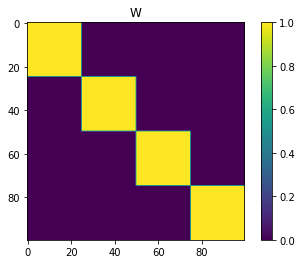

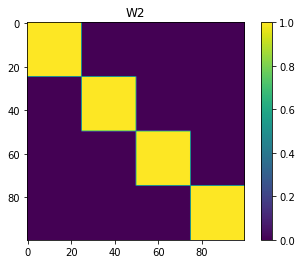

created 8 batches
created 2 batches


/var/folders/2v/8f66tcbn07n474q76db1wfyc0000gn/T/ipykernel_3176/1485293874.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X_train).to(device=device),torch.tensor(X_test).to(device=device),torch.tensor(y_train).to(device=device),torch.tensor(y_test).to(device=device),torch.tensor(train_batch_ids).to(device=device),torch.tensor(test_batch_ids).to(device=device)


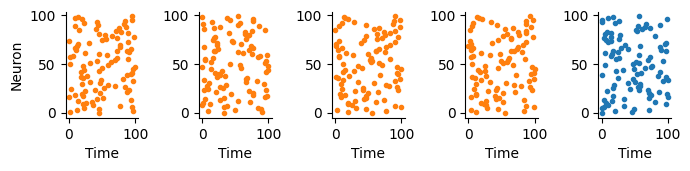

In [4]:
N=100
T=100
batch_size=40
nb_classes=4
W,W2 = get_Ws(N=N,nb_classes=nb_classes,epsilon=1)

X_train,X_test,y_train, y_test, train_batch_ids,test_batch_ids =create_data(N=N,T=T,batch_size=batch_size,nb_classes=nb_classes,nb_samples=100,alpha=2.0)


In [5]:
losses = np.zeros((100,5))
for i in range(1):
    model = OneHiddenModel(in_channels=N,hidden_channels=N,out_channels=nb_classes,batch_size=batch_size)
    loss, acc = train(N,T,nb_classes,model,X_train,y_train,train_batch_ids,W=W,W2=W2,lr=1e-4,decay=.99,use_W=True,use_W2=True,print_each=5,epochs=100)
    losses[:,i]=loss

/Users/svenkerstjens/msc-thesis/MSc-thesis/LIFlayer.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.layer2.fc_layer.weight = torch.nn.Parameter((self.layer2.fc_layer.weight.data * torch.tensor(W)).float())


epoch 0: 
 loss: 5.0336103439331055
train_acc: 0.22187499701976776
epoch 5: 
 loss: 1.3332240581512451
train_acc: 0.3906249701976776
epoch 10: 
 loss: 1.2752728462219238
train_acc: 0.4124999940395355
epoch 15: 
 loss: 1.1333985328674316
train_acc: 0.4999999701976776
epoch 20: 
 loss: 1.036373257637024
train_acc: 0.559374988079071
epoch 25: 
 loss: 0.9498627185821533
train_acc: 0.6937499642372131
epoch 30: 
 loss: 0.8926375508308411
train_acc: 0.684374988079071
epoch 35: 
 loss: 0.7845977544784546
train_acc: 0.7937499284744263
epoch 40: 
 loss: 0.6887979507446289
train_acc: 0.8218750357627869
epoch 45: 
 loss: 0.5950890183448792
train_acc: 0.878125011920929
epoch 50: 
 loss: 0.5779174566268921
train_acc: 0.878125011920929
epoch 55: 
 loss: 0.5163261890411377
train_acc: 0.893750011920929
epoch 60: 
 loss: 0.43247365951538086
train_acc: 0.9312500357627869
epoch 65: 
 loss: 0.3995130658149719
train_acc: 0.9312499761581421
epoch 70: 
 loss: 0.3325474262237549
train_acc: 0.9656249284744263
e

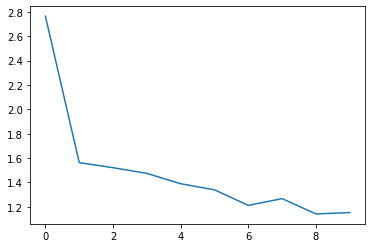

In [8]:
#plt.plot(loss)
plt.plot(loss)

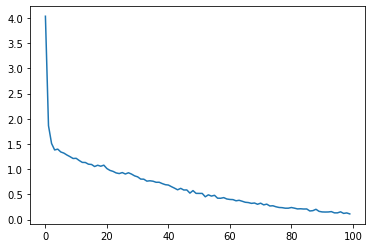

In [15]:
plt.plot(losses[:,0])

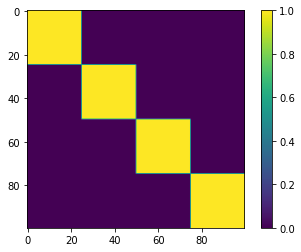

In [11]:
plt.imshow(W)
plt.colorbar()

<generator object Module.parameters at 0x148244c80>

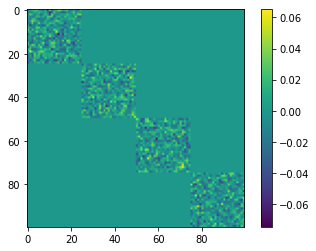

In [6]:
plt.imshow(model.layer2.fc_layer.weight.detach().numpy())
plt.colorbar()

model.parameters()

In [40]:
val_acc,_,_ = validation_acc(X_test,y_test,model,test_batch_ids)
#val_acc_hist = val_acc_hist + [val_acc]
print(f'val_acc: {val_acc}')

val_acc: 0.949999988079071


In [39]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0201, -0.0013, -0.0930,  ..., -0.0308, -0.0192, -0.0351],
         [-0.0117,  0.0138,  0.0164,  ...,  0.0101,  0.0409,  0.0102],
         [-0.0328,  0.0142, -0.0103,  ..., -0.0085, -0.0198,  0.0035],
         ...,
         [-0.0533, -0.0148, -0.0104,  ...,  0.0408, -0.0040, -0.0199],
         [ 0.0096, -0.0157,  0.0079,  ..., -0.0187,  0.0226, -0.0077],
         [-0.0110, -0.0613,  0.0183,  ..., -0.0196,  0.0549, -0.0095]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0023,  0.0113, -0.0099, -0.0003,  0.0011, -0.0046, -0.0078,  0.0006,
         -0.0022, -0.0093, -0.0060, -0.0080, -0.0041,  0.0114, -0.0041,  0.0034,
          0.0057, -0.0082,  0.0060, -0.0066, -0.0007, -0.0015, -0.0048, -0.0008,
          0.0078,  0.0114, -0.0093, -0.0074,  0.0108, -0.0039, -0.0019,  0.0050,
          0.0028,  0.0121,  0.0143,  0.0074, -0.0027,  0.0016,  0.0001, -0.0016,
          0.0031,  0.0089,  0.0035, -0.0005,  0.0027, -0.0118,  0.0021, -0.0053